In [1]:
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors

import tensorflow as tf

In [3]:
file_pattern = 'dataset/next_day_wildfire_spread_train*'
file_pattern_eval = 'dataset/next_day_wildfire_spread_eval*'

In [4]:
"""Constants for the data reader."""

INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph', 
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

OUTPUT_FEATURES = ['FireMask', ]

# Data statistics 
# For each variable, the statistics are ordered in the form:
# (min_clip, max_clip, mean, standard deviation)
DATA_STATS = {
    # Elevation in m.
    # 0.1 percentile, 99.9 percentile
    'elevation': (0.0, 3141.0, 657.3003, 649.0147),
    # Pressure
    # 0.1 percentile, 99.9 percentile
    'pdsi': (-6.12974870967865, 7.876040384292651, -0.0052714925, 2.6823447),
    'NDVI': (-9821.0, 9996.0, 5157.625, 2466.6677),  # min, max
    # Precipitation in mm.
    # Negative values do not make sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, 44.53038024902344, 1.7398051, 4.482833),
    # Specific humidity.
    # Negative values do not make sense, so min is set to 0.
    # The range of specific humidity is up to 100% so max is 1.
    'sph': (0., 1., 0.0071658953, 0.0042835088),
    # Wind direction in degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th': (0., 360.0, 190.32976, 72.59854),
    # Min/max temperature in Kelvin.
    # -20 degree C, 99.9 percentile
    'tmmn': (253.15, 298.94891357421875, 281.08768, 8.982386),
    # -20 degree C, 99.9 percentile
    'tmmx': (253.15, 315.09228515625, 295.17383, 9.815496),
    # Wind speed in m/s.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs': (0.0, 10.024310074806237, 3.8500874, 1.4109988),
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc': (0.0, 106.24891662597656, 37.326267, 20.846027),
    # Population density
    # min, 99.9 percentile
    'population': (0., 2534.06298828125, 25.531384, 154.72331),
    # We don't want to normalize the FireMasks.
    # 1 indicates fire, 0 no fire, -1 unlabeled data
    'PrevFireMask': (-1., 1., 0., 1.),
    'FireMask': (-1., 1., 0., 1.)
}

In [5]:
"""Library of common functions used in deep learning neural networks.
"""
def random_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
    num_in_channels: int,
    num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Randomly axis-align crop input and output image tensors.

    Args:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
    sample_size: side length (square) to crop to.
    num_in_channels: number of channels in input_img.
    num_out_channels: number of channels in output_img.
    Returns:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
    """
    combined = tf.concat([input_img, output_img], axis=2)
    combined = tf.image.random_crop(
      combined,
      [sample_size, sample_size, num_in_channels + num_out_channels])
    input_img = combined[:, :, 0:num_in_channels]
    output_img = combined[:, :, -num_out_channels:]
    return input_img, output_img


def center_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Center crops input and output image tensors.

    Args:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
    sample_size: side length (square) to crop to.
    Returns:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
    """
    central_fraction = sample_size / input_img.shape[0]
    input_img = tf.image.central_crop(input_img, central_fraction)
    output_img = tf.image.central_crop(output_img, central_fraction)
    return input_img, output_img

In [6]:
"""Dataset reader for Earth Engine data."""

def _get_base_key(key: Text) -> Text:
    """Extracts the base key from the provided key.

    Earth Engine exports TFRecords containing each data variable with its
    corresponding variable name. In the case of time sequences, the name of the
    data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
    where 'variable' is the name of the variable, and n the number of elements
    in the time sequence. Extracting the base key ensures that each step of the
    time sequence goes through the same normalization steps.
    The base key obeys the following naming pattern: '([a-zA-Z]+)'
    For instance, for an input key 'variable_1', this function returns 'variable'.
    For an input key 'variable', this function simply returns 'variable'.

    Args:
    key: Input key.

    Returns:
    The corresponding base key.

    Raises:
    ValueError when `key` does not match the expected pattern.
    """
    match = re.match(r'([a-zA-Z]+)', key)
    if match:
        return match.group(1)
    raise ValueError(
      'The provided key does not match the expected pattern: {}'.format(key))


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
    """Clips and rescales inputs with the stats corresponding to `key`.

    Args:
    inputs: Inputs to clip and rescale.
    key: Key describing the inputs.

    Returns:
    Clipped and rescaled input.

    Raises:
    ValueError if there are no data statistics available for `key`.
    """
    base_key = _get_base_key(key)
    if base_key not in DATA_STATS:
        raise ValueError(
            'No data statistics available for the requested key: {}.'.format(key))
    min_val, max_val, _, _ = DATA_STATS[base_key]
    inputs = tf.clip_by_value(inputs, min_val, max_val)
    return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
    """Clips and normalizes inputs with the stats corresponding to `key`.

    Args:
    inputs: Inputs to clip and normalize.
    key: Key describing the inputs.

    Returns:
    Clipped and normalized input.

    Raises:
    ValueError if there are no data statistics available for `key`.
    """
    base_key = _get_base_key(key)
    if base_key not in DATA_STATS:
        raise ValueError(
            'No data statistics available for the requested key: {}.'.format(key))
    min_val, max_val, mean, std = DATA_STATS[base_key]
    inputs = tf.clip_by_value(inputs, min_val, max_val)
    inputs = inputs - mean
    return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
    """Creates a features dictionary for TensorFlow IO.

    Args:
    sample_size: Size of the input tiles (square).
    features: List of feature names.

    Returns:
    A features dictionary for TensorFlow IO.
    """
    sample_shape = [sample_size, sample_size]
    features = set(features)
    columns = [
      tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
      for _ in features
    ]
    return dict(zip(features, columns))


def _parse_fn(
    example_proto: tf.train.Example, data_size: int, sample_size: int,
    num_in_channels: int, clip_and_normalize: bool,
    clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Reads a serialized example.

    Args:
    example_proto: A TensorFlow example protobuf.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    num_in_channels: Number of input channels.
    clip_and_normalize: True if the data should be clipped and normalized.
    clip_and_rescale: True if the data should be clipped and rescaled.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data should be cropped in the center.

    Returns:
    (input_img, output_img) tuple of inputs and outputs to the ML model.
    """
    if (random_crop and center_crop):
        raise ValueError('Cannot have both random_crop and center_crop be True')
    input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
    feature_names = input_features + output_features
    features_dict = _get_features_dict(data_size, feature_names)
    features = tf.io.parse_single_example(example_proto, features_dict)

    if clip_and_normalize:
        inputs_list = [
            _clip_and_normalize(features.get(key), key) for key in input_features
        ]
    elif clip_and_rescale:
        inputs_list = [
            _clip_and_rescale(features.get(key), key) for key in input_features
        ]
    else:
        inputs_list = [features.get(key) for key in input_features]

    inputs_stacked = tf.stack(inputs_list, axis=0)
    input_img = tf.transpose(inputs_stacked, [1, 2, 0])

    outputs_list = [features.get(key) for key in output_features]
    assert outputs_list, 'outputs_list should not be empty'
    outputs_stacked = tf.stack(outputs_list, axis=0)

    outputs_stacked_shape = outputs_stacked.get_shape().as_list()
    assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
    output_img = tf.transpose(outputs_stacked, [1, 2, 0])

    if random_crop:
        input_img, output_img = random_crop_input_and_output_images(
            input_img, output_img, sample_size, num_in_channels, 1)
    if center_crop:
        input_img, output_img = center_crop_input_and_output_images(
            input_img, output_img, sample_size)
    return input_img, output_img


def get_dataset(file_pattern: Text, data_size: int, sample_size: int,
                batch_size: int, num_in_channels: int, compression_type: Text,
                clip_and_normalize: bool, clip_and_rescale: bool,
                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
    """Gets the dataset from the file pattern.

    Args:
    file_pattern: Input file pattern.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    batch_size: Batch size.
    num_in_channels: Number of input channels.
    compression_type: Type of compression used for the input files.
    clip_and_normalize: True if the data should be clipped and normalized, False
      otherwise.
    clip_and_rescale: True if the data should be clipped and rescaled, False
      otherwise.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data shoulde be cropped in the center.

    Returns:
    A TensorFlow dataset loaded from the input file pattern, with features
    described in the constants, and with the shapes determined from the input
    parameters to this function.
    """
    if (clip_and_normalize and clip_and_rescale):
        raise ValueError('Cannot have both normalize and rescale.')
    dataset = tf.data.Dataset.list_files(file_pattern)
    dataset = dataset.interleave(
      lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(
      lambda x: _parse_fn(  # pylint: disable=g-long-lambda
          x, data_size, sample_size, num_in_channels, clip_and_normalize,
          clip_and_rescale, random_crop, center_crop),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [7]:
train_dataset = get_dataset(
      file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

eval_dataset = get_dataset(
      file_pattern_eval,
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

In [8]:
inputs, labels = next(iter(train_dataset))

In [9]:
TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

In [10]:
# Number of rows of data samples to plot
n_rows = 5 
# Number of data variables
n_features = inputs.shape[3]
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

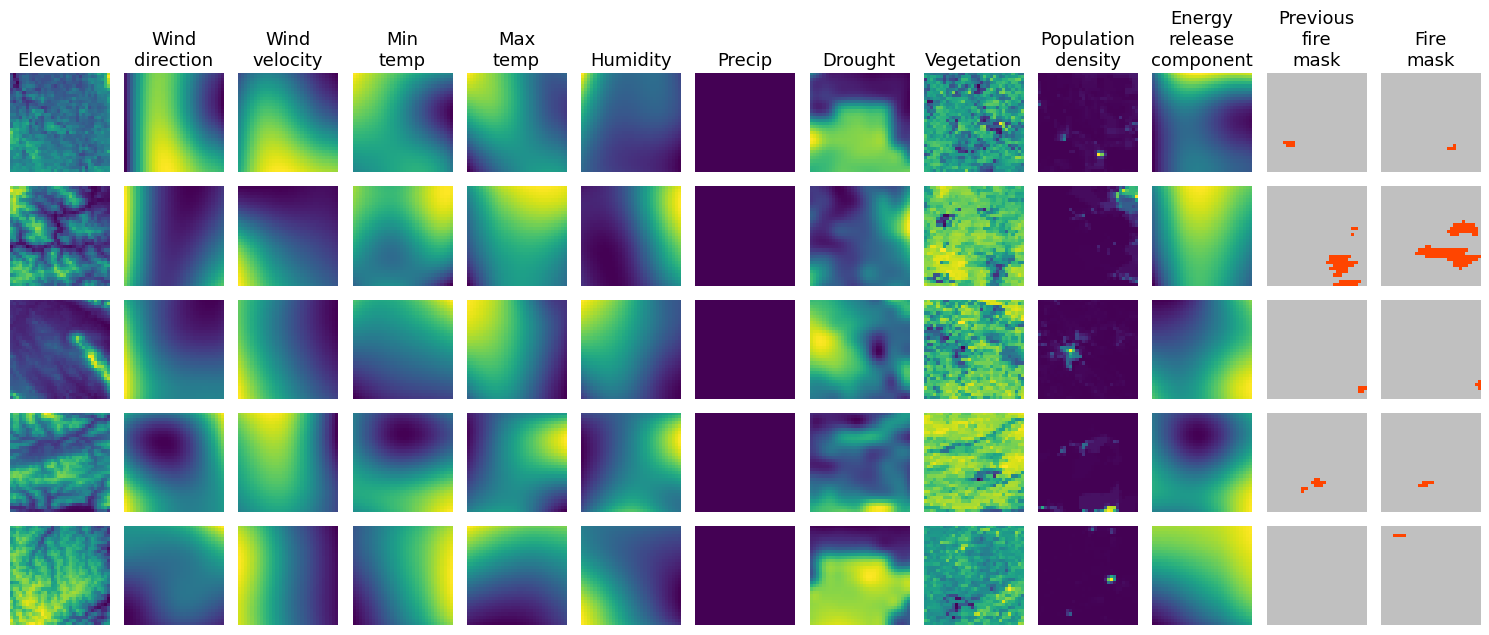

In [11]:
fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
    for j in range(n_features + 1):
        plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
        if i == 0:
            plt.title(TITLES[j], fontsize=13)
        if j < n_features - 1:
            plt.imshow(inputs[i, :, :, j], cmap='viridis')
        if j == n_features - 1:
            plt.imshow(inputs[i, :, :, -1], cmap=CMAP, norm=NORM)
        if j == n_features:
            plt.imshow(labels[i, :, :, 0], cmap=CMAP, norm=NORM) 
        plt.axis('off')
plt.tight_layout()

In [12]:
print(type(train_dataset))
print(train_dataset)
print(type(eval_dataset))
print(eval_dataset)

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<PrefetchDataset shapes: ((None, 32, 32, 12), (None, 32, 32, 1)), types: (tf.float32, tf.float32)>
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<PrefetchDataset shapes: ((None, 32, 32, 12), (None, 32, 32, 1)), types: (tf.float32, tf.float32)>


In [13]:
# check GPU info

# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# from tensorflow.python.client import device_lib 
# print(device_lib.list_local_devices())

## Training 

In [14]:
import model_resunet
# import model_satunet
import glob
import os
import sys
import keras
from metrics import dice_coef, get_loss_function

# Get loss function
loss_function = get_loss_function('dice_coef_loss')

# Define model architecture
model = model_resunet.get_model([32,32,12])

# Callbacks
import wandb
from wandb.keras import WandbCallback

callbacks = list()

# Optional: WandB callback config and init
config = {
    "dataset_id": "NDFP_data",
    "img_size": [64,64],
    "model_architecture": 'resunet',
    "num_layers_satunet": 4,
    "unfreeze_all_layers": False,
    "parent_model_name": None,
    "optimizer": 'adam',
    "learning_rate": 0.0001,
    "loss_function": 'dice_coef_loss',
    "epochs": 100,
    "batch_size": 100,
    "custom_objects": [
        "dice_coef",
        "focal_tversky_loss"
        ],
    "input_features": INPUT_FEATURES
    }
wandb.init(project='fire-model', config=config)
run_name = wandb.run.name
callbacks.append(WandbCallback())

# Define learning rate schedule callback
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.0001, decay_steps=15, decay_rate=0.96, staircase=True
    )

# Define checkpoints callback
checkpoint_path = os.path.join('./output', 'model', 'fire_model_{}.h5'.format(run_name))
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, save_weights_only=True, save_best_only=True
    )
callbacks.append(checkpoint_cb)

# Define Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [15]:
# Compile and train model
model.compile(
    optimizer=optimizer,
    loss=loss_function, metrics=[dice_coef,
                                 tf.keras.metrics.AUC(curve="PR"),
                                 tf.keras.metrics.Precision(),
                                 tf.keras.metrics.Recall()
                                ]
    )

history = model.fit(
    train_dataset,
    validation_data=eval_dataset,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
    150/Unknown - 110s 694ms/step - loss: 0.9407 - dice_coef: 0.0594 - auc: 0.0517 - precision: 0.0540 - recall: 0.3317

D:\anaconda\envs\tensorflow\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: E:\nextdayfire\wandb\run-20231107_182549-5jpwxj59\files\model-best\assets


INFO:tensorflow:Assets written to: E:\nextdayfire\wandb\run-20231107_182549-5jpwxj59\files\model-best\assets
wandb: Adding directory to artifact (E:\nextdayfire\wandb\run-20231107_182549-5jpwxj59\files\model-best)... Done. 0.1s


150/150 [==============================] - 122s 774ms/step - loss: 0.9407 - dice_coef: 0.0594 - auc: 0.0517 - precision: 0.0540 - recall: 0.3317 - val_loss: 0.9153 - val_dice_coef: 0.0848 - val_auc: 0.0599 - val_precision: 0.0650 - val_recall: 0.1715
Epoch 2/100
150/150 [==============================] - 117s 781ms/step - loss: 0.8938 - dice_coef: 0.1061 - auc: 0.0585 - precision: 0.0739 - recall: 0.1642 - val_loss: 0.9270 - val_dice_coef: 0.0725 - val_auc: 0.0584 - val_precision: 0.0560 - val_recall: 0.0150
Epoch 3/100
150/150 [==============================] - 123s 822ms/step - loss: 0.9380 - dice_coef: 0.0620 - auc: 0.0487 - precision: 0.0556 - recall: 0.0430 - val_loss: 1.1224 - val_dice_coef: -0.1206 - val_auc: 0.0501 - val_precision: 0.0291 - val_recall: 0.0198
Epoch 4/100
150/150 [==============================] - 117s 780ms/step - loss: 1.0174 - dice_coef: -0.0173 - auc: 0.0420 - precision: 0.0308 - recall: 0.0635 - val_loss: 0.9780 - val_dice_coef: 0.0219 - val_auc: 0.0512 - v

D:\anaconda\envs\tensorflow\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: E:\nextdayfire\wandb\run-20231107_182549-5jpwxj59\files\model-best\assets


INFO:tensorflow:Assets written to: E:\nextdayfire\wandb\run-20231107_182549-5jpwxj59\files\model-best\assets
wandb: Adding directory to artifact (E:\nextdayfire\wandb\run-20231107_182549-5jpwxj59\files\model-best)... Done. 0.1s


150/150 [==============================] - 126s 842ms/step - loss: 1.0050 - dice_coef: -0.0049 - auc: 0.0416 - precision: 0.0322 - recall: 0.0742 - val_loss: 0.8444 - val_dice_coef: 0.1539 - val_auc: 0.0495 - val_precision: 0.0131 - val_recall: 8.2951e-04
Epoch 67/100
150/150 [==============================] - 113s 751ms/step - loss: 1.0048 - dice_coef: -0.0047 - auc: 0.0418 - precision: 0.0329 - recall: 0.0751 - val_loss: 0.9915 - val_dice_coef: 0.0086 - val_auc: 0.0506 - val_precision: 0.0052 - val_recall: 3.7345e-04
Epoch 68/100
150/150 [==============================] - 113s 753ms/step - loss: 1.0058 - dice_coef: -0.0057 - auc: 0.0418 - precision: 0.0329 - recall: 0.0756 - val_loss: 0.9952 - val_dice_coef: 0.0049 - val_auc: 0.0510 - val_precision: 0.0063 - val_recall: 7.1437e-04
Epoch 69/100
150/150 [==============================] - 118s 786ms/step - loss: 1.0008 - dice_coef: -7.6109e-04 - auc: 0.0415 - precision: 0.0317 - recall: 0.0737 - val_loss: 0.9891 - val_dice_coef: 0.0110 

## Evaluation

1/1 [==============================] - 0s 69ms/step
Accuracy: 0.933397


D:\anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


score_a (array([0.        , 0.94522964, 0.01374602]), array([0.        , 0.98720037, 0.00642608]), array([0.        , 0.96575922, 0.00875794]), array([  47571, 1634969,   46996], dtype=int64))
precision 0.933397165482534
Recall: 0.933397
F1 score: 0.933397
[[      0   46830     741]
 [      0 1614042   20927]
 [      0   46694     302]]
Accuracy: 0.933173
score_a (array([0.12474918, 0.95303549, 0.40003807]), array([0.05358307, 0.97787726, 0.26827815]), array([0.07496618, 0.96529658, 0.32116974]), array([  47571, 1634969,   46996], dtype=int64))
precision 0.93317282785672
Recall: 0.933173
F1 score: 0.933173
[[   2549   44669     353]
 [  17614 1598799   18556]
 [    270   34118   12608]]


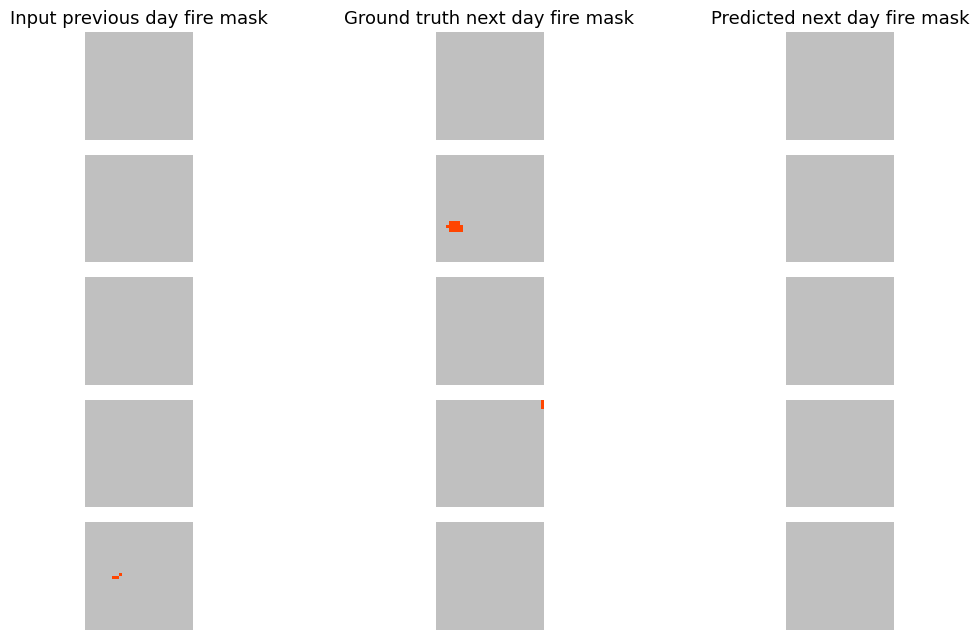

In [24]:
# # Define ResUNet model
# model = model_resunet.get_model([model_config["IMG_SIZE"][0],model_config["IMG_SIZE"][1],len(dataset_config["INPUT_FEATURES"])])

# # Load model weights
# model.load_weights(os.path.join(model_paths[0]))

file_pattern_test = 'dataset/next_day_wildfire_spread_test*'

test_dataset = get_dataset(
      file_pattern_test,
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

import numpy as np

# Get all samples from TFRecords in arrays
first_it = True
for x, y in test_dataset:
    if first_it:
        test_data_inputs = x
        test_data_targets = y
        first_it = False
    else:
        test_data_inputs = np.concatenate((test_data_inputs, x), axis=0)        
        test_data_targets = np.concatenate((test_data_targets, y), axis=0)        
test_data_inputs = np.asarray(test_data_inputs)
y_true = np.asarray(test_data_targets)

# Predict
y_pred=list()
for sample in test_data_inputs:
    sample_exp = np.expand_dims(sample, axis=0)
    pred = model.predict(sample_exp)
    y_pred.append(pred)
masks = np.round(y_pred)

# Evaluate using sklearn
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# Flatten results before evaluation
previous_fire_mask_flat = test_data_inputs[:, :, :, -1].flatten()
persistence_mask_flat = previous_fire_mask_flat
y_pred_mask_flat = np.expand_dims(np.array(y_pred).squeeze(), axis=-1).flatten()
masks_flat = masks.flatten()
y_true_flat = y_true.flatten()

# Metrics for predicitions
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_true_flat, masks_flat)
print('Accuracy: %f' % accuracy)
score_a = score(y_true_flat, masks_flat)
print("score_a", score_a)
# precision tp / (tp + fp)
precision = precision_score(y_true_flat, masks_flat, average='micro')
print("precision", precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true_flat, masks_flat, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true_flat, masks_flat, average='micro')
print('F1 score: %f' % f1)
# confusion matrix
matrix = confusion_matrix(y_true_flat, masks_flat)
print(matrix)

# # Metrics for baseline
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_true_flat, persistence_mask_flat)
print('Accuracy: %f' % accuracy)
score_a = score(y_true_flat, persistence_mask_flat)
print("score_a", score_a)
# precision tp / (tp + fp)
precision = precision_score(y_true_flat, persistence_mask_flat, average='micro')
print("precision", precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true_flat, persistence_mask_flat, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true_flat, persistence_mask_flat, average='micro')
print('F1 score: %f' % f1)
# confusion matrix
matrix = confusion_matrix(y_true_flat, persistence_mask_flat)
print(matrix)


# Output visualisation
output_titles = ["Input previous day fire mask", "Ground truth next day fire mask", "Predicted next day fire mask" ]

n_rows = 5
n_features = len(output_titles)

CMAP = colors.ListedColormap(['silver', 'orangered'])
BOUNDS = [0., 1.]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
    for j in range(n_features):
        plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
        if i == 0:
            plt.title(output_titles[j], fontsize=13)
        if j == 0:
            plt.imshow(test_data_inputs[i, :, :, -1], cmap=CMAP, norm=NORM) 
        if j == 1:
            plt.imshow(y_true[i, :, :, 0], cmap=CMAP, norm=NORM)
        if j == 2:
            plt.imshow(masks.squeeze(axis=1)[i, :, :, 0], cmap=CMAP, norm=NORM) 
        plt.axis('off')
plt.tight_layout()